# Trained model visualisation and evaluation

In [2]:
import os
import sys
import wfdb

sys.path.append(os.path.abspath(os.path.join('/workspaces/ECG-ML-Challenge/notebooks/', "..")))
from src import dataset
from src import config
from src.visualization import plot_ecg

import numpy as np

Signal: ['MLII', 'V1']
Frequency: 360


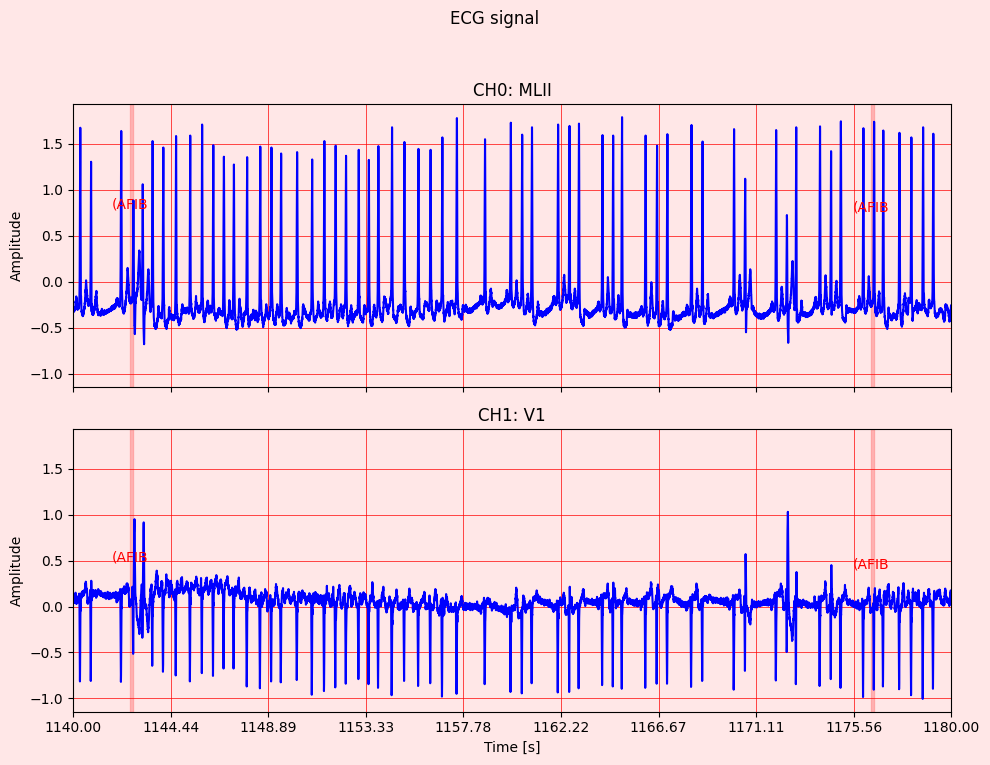

In [13]:
signal = '202'
t_start = 1140
t_end = 1180

record = wfdb.rdrecord(os.path.join(config.RAW_DATA_DIR, 'mitdb', signal))
annotation = wfdb.rdann(os.path.join(config.RAW_DATA_DIR, 'mitdb', signal), 'atr')
print(f'Signal: {record.sig_name}')
print(f'Frequency: {record.fs}')
_ = plot_ecg(record, record.fs, t_start=t_start, t_end=t_end, annotation=annotation)

In [4]:
import torch
from src.model import models

model_file = 'GPTMultiScaleConvGRUModel_20241119_1920_15_192_0.001.pth'
model = models.GPTMultiScaleConvGRUModel()
model.load_state_dict(torch.load(os.path.join(config.MODELS_DIR, model_file), map_location=torch.device('cpu')))
model.eval()

/tmp/ipykernel_18517/3629545198.py:6: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(os.path.join(config.MODELS_DIR, model_file), map_locatio

GPTMultiScaleConvGRUModel(
  (conv1_1): Conv1d(1, 16, kernel_size=(3,), stride=(1,), padding=(1,))
  (conv1_2): Conv1d(16, 32, kernel_size=(3,), stride=(1,), padding=(1,))
  (conv1_3): Conv1d(32, 64, kernel_size=(3,), stride=(1,), padding=(1,))
  (shortcut1): Conv1d(1, 64, kernel_size=(1,), stride=(1,))
  (conv2_1): Conv1d(1, 16, kernel_size=(7,), stride=(1,), padding=(3,))
  (conv2_2): Conv1d(16, 32, kernel_size=(7,), stride=(1,), padding=(3,))
  (conv2_3): Conv1d(32, 64, kernel_size=(7,), stride=(1,), padding=(3,))
  (shortcut2): Conv1d(1, 64, kernel_size=(1,), stride=(1,))
  (conv3_1): Conv1d(1, 16, kernel_size=(15,), stride=(1,), padding=(7,))
  (conv3_2): Conv1d(16, 32, kernel_size=(15,), stride=(1,), padding=(7,))
  (conv3_3): Conv1d(32, 64, kernel_size=(15,), stride=(1,), padding=(7,))
  (shortcut3): Conv1d(1, 64, kernel_size=(1,), stride=(1,))
  (norm1): LayerNorm((192,), eps=1e-05, elementwise_affine=True)
  (gru): GRU(192, 128, num_layers=3, batch_first=True, bidirectional=Tr

Input signal shape: (2, 451388)
Applying padding of size 612 to the data.
Padded signal shape: (2, 452000)
Number of chunks: 225


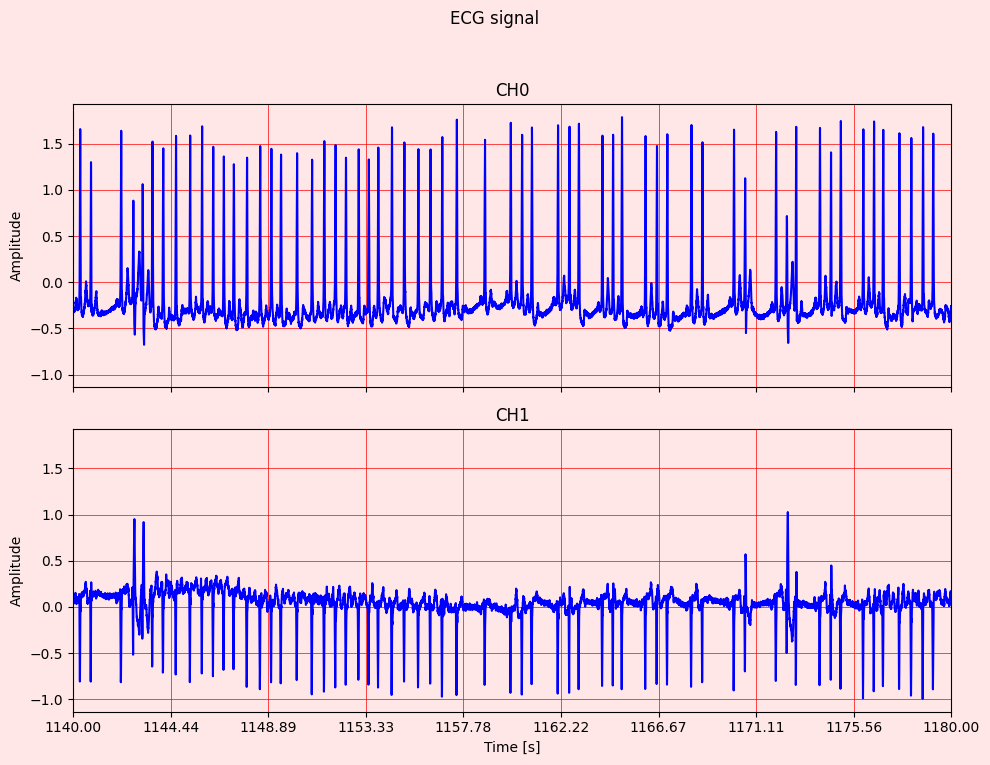

In [14]:
import wfdb.processing

TRAINED_CHUNK_SIZE = 2000
TRAINED_FS = 250

signals = []
for i in range(record.n_sig):
    signal, _ = wfdb.processing.resample_sig(record.p_signal.T[i, ...], record.fs, TRAINED_FS)
    signals.append(signal)
signal = np.array(signals)

ch, sig_len = signal.shape
print(f'Input signal shape: {signal.shape}')

if sig_len % TRAINED_CHUNK_SIZE != 0:
    padding = TRAINED_CHUNK_SIZE - (sig_len % TRAINED_CHUNK_SIZE)
    print(f"Applying padding of size {padding} to the data.")
    signal = np.pad(signal, ((0, 0), (0, padding)), "constant")
    print(f'Padded signal shape: {signal.shape}')

num_chunks = sig_len // TRAINED_CHUNK_SIZE
chunks = [signal[:, i * TRAINED_CHUNK_SIZE : (i + 1) * TRAINED_CHUNK_SIZE] for i in range(num_chunks)]
print(f'Number of chunks: {len(chunks)}')

_ = plot_ecg(signal.T, TRAINED_FS, t_start=t_start, t_end=t_end)

In [15]:
from sklearn.preprocessing import normalize
from matplotlib import pyplot as plt

Y = []
for chunk in chunks:
    chunk = normalize(chunk, axis=1)

    x = torch.tensor(chunk, dtype=torch.float32)

    with torch.no_grad():
        y = model(x)

    Y.append(y.numpy())
    
y = np.concatenate(Y, axis=1)
print(y.shape)

(2, 450000)


In [16]:
(y > 0.5).sum(axis=1)

array([0, 0])

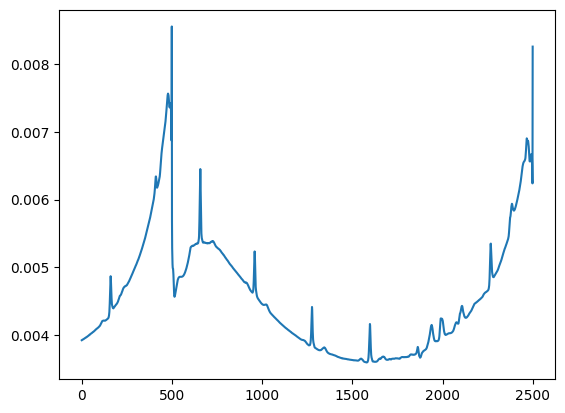

In [9]:
plt.plot(y[0, TRAINED_FS*t_start: TRAINED_FS*t_end])   